# Natural Language Processing

```{warning}
This chapter is in progress 
```

Working with written language is called natural language processing (NLP) and is a much broader field than deep learning. We'll focus just on deep learning in NLP and specifically it's application to molecules and materials. NLP in chemistry would at first appear to be a rich area, especially with the large amount of historic chemistry data existing only in plain text. However, the most work in this area has been on representations of molecules *as text* via the SMILES {cite} or SELFIES {cite} encoding. To a large extent, this is another way of "featurizing" molecules without resorting to descriptors. This is obviously an essential task in working with molecular data, but I think there are still many important opportunities to explore NLP in areas aside from featurizing molecules. 

One advantage of working with molecules as text relative to graph neural networks (GNNs) is that existing ML frameworks are geared towards working with text. Another reason is that it is easier to train generative models because generating valid text is easier than generating valid graphs. You'll thus see generative/unsupervised learning of chemical space more often done with NLP, whereas GNNs are typically better for supervised learning tasks and can incorporate spatial features. NLP is also used beyond encoding molecules. NLP can be used to understand textual descriptions of materials and molecules, which is essential for *materials* that are defined with more than just the moluecular structure.

```{margin}
I'm going to completely skip recurrent neural networks (RNNs). Although they have been historically important, I think they've been displaced by transformers and so we'll save some space.
```

## Converting Molecules into Text

Before we can begin to use neural networks, we need to convert molecules into text. Simplified molecular-input line-entry system (SMILES) is a de facto standard for converting molecules into a string. SMILES enables molecular structures to be correctly saved in spreadsheets, databases, and input to models that work on sequences like text. Here's an example SMILES string: `CC(NC)CC1=CC=C(OCO2)C2=C1`. SMILES was crucial to the field of cheminformatics and is widely used today beyond deep learning. Some of the first deep learning work was with SMILES strings because of the ability to apply NLP models to SMILES strings. 

Let us imagine SMILES as a function whose domain is molecular graphs (or some equivalent complete description of a molecule) and the image is a string. The SMILES function is not surjective -- there are many strings which are not valid SMILES strings. The SMILES function is injective -- each graph has at least one SMILES string. The non-surjectivity actually causes some problems in generative models because strings which look like valid SMILES are actually not. The inverse function, going from SMILES string to molecular graph, is non-injective. There are multiply SMILES strings that map to the same molecular graph.  This arises from the grammar of SMILES, which allows multiply ways to specify a ring and implicit vs explicit valency or hydrogens. The inverse function is surjective -- every molecular graph has at least one valid SMILES. 

If you've read the previous chapters on equivariances ({doc}`data` and {doc}`Equivariant`), a natural question is if SMILES is permutation equivariant or permutation invariant. That is, if you change the order of atoms in a way that has no effect on chemistry, is the SMILES string identical? *Sort of*. There is an extra step in making a SMILES string called canonicalization. Because multiple SMILES strings map to the same molecular graph, SMILES parsers have a systematic way of choosing a single *canonical* SMILES string to represent all the equivalent ones. *Canonical SMILES* are thus permutation invariant. 

### SELFIES

Recent work from Krenn et al. developed an alternative approach to SMILES called SELF-referencIng Embedded Strings (SELFIES){cite}`Krenn_2020`. SELFIES is surjective -- meaning every string is a valid molecule. Do note that the characters in SELFIES are not all ASCII characters, so it's not like every sentence encodes a molecule. The SELFIES function is thus bijective, which makes it an excellent choice for generative models. SELFIES, as of 2021, is not directly canonicalized though and thus is not permutation invariant by itself. However, if you add canonical SMILES as an intermediate step, then SELFIES are canonical. It seems that models which output a molecule (generative or supervised) benefit from using SELFIES instead of SMILES because the model does not need to learn how to make valid strings -- all strings are already valid SELFIES {cite}`rajan2020decimer`. This benefit is less clear in supervised learning and no difference has been observed{cite}`chithrananda2020chemberta`.

## Running This Notebook


Click the &nbsp;<i aria-label="Launch interactive content" class="fas fa-rocket"></i>&nbsp; above to launch this page as an interactive Google Colab. See details below on installing packages, either on your own environment or on Google Colab

````{tip} My title
:class: dropdown
To install packages, execute this code in a new cell

**For Google Colab**

```
!wget -c https://repo.continuum.io/miniconda/Miniconda3-py37_4.8.3-Linux-x86_64.sh
!chmod +x Miniconda3-py37_4.8.3-Linux-x86_64.sh
!time bash ./Miniconda3-py37_4.8.3-Linux-x86_64.sh -b -f -p /usr/local
!time conda install -q -y -c conda-forge rdkit

import sys
sys.path.append('/usr/local/lib/python3.7/site-packages/')

!conda install -c conda-forge graphviz
!pip install jupyter-book matplotlib numpy tensorflow pydot seaborn Pillow
```

**For Conda Env**

```
!conda install -c conda-forge graphviz
!pip install jupyter-book matplotlib numpy tensorflow pydot seaborn Pillow
```

````

## Recurrent Neural Networks

```{margin}
String is a synonym for sequence here. Character and symbol are synonyms for token (single element of the string).
```

Recurrent neural networks (RNN) have been by far the most popular approach to working with molecular strings. RNNs have a critical property that they can have different length input sequences, making it appropriate for SMILES or SELFIES which both have variable length. RNNs have recurrent layers that consume an input sequence element-by-element. Consider an input vector $\vec{x} = \left[x_0, x_1,\ldots,x_L\right]$. The RNN layer function is binary and takes as input the $i$th element of the input sequence and the output from the $i - 1$ layer function. You can write it as:

\begin{equation}
f(f\ldots f(x_0,\vec{0}), x_1), x_2)\ldots x_L)
\end{equation}

Commonly we would like to actually see and look at the these intermediate outputs from the layer function $f_4(x_4, f_3(\ldots)) = \vec{h}_4$. These $\vec{h}$s are called the hidden state because of the connection between RNNs and Markov State Models. We can **unroll** our picture of an RNN to be:

```{figure} ./rnn.jpg
----
name: rnn
width: 400px
----
Unrolled picture of RNN. 
```

where the initial hidden state is assumed to be $\vec{0}$, but could be trained. The output at the end is shown as $\vec{y}$. *Notice there are no subscripts on $f$ because we use the same function and weights at each step*. This re-use of weights makes the choice of parameter number independent of input lengths, which is also necessary to make the RNN accommodate arbitrary length input sequences. It should be noted that the length of $\vec{y}$ may be a function of the input length, so that the $\vec{h}_i$ may be increasing in length at each step to enable an output $\vec{y}$. Some diagrams of RNNs will show that by indicating a growing output sequence as an additional output from $f(x_i, h_{i-1})$.

Interestingly, the form of $f(x, \vec{h})$ is quite flexible based on the discussion above. There have been hundreds of ideas for the function $f$ and it is problem dependent. The two most common are long short-term memory (LSTM) units and gated recurrent unit (GRU). You can spend quite a bit of time trying to reason about [these functions](http://d2l.ai/chapter_recurrent-modern/gru.html), understanding how [gradients propagate nicely through them](http://d2l.ai/chapter_recurrent-neural-networks/bptt.html), and there is an analogy about how they are inspired by human memory. Ultimately, they are used because they perform well and are widely-implemented so we do not need to spend much time on these details. The main thing to know is that GRUs are simpler and faster, but LSTMs seem to be better at more difficult sequences. Note that $\vec{h}$ is typically 1-3 different quantities in modern implementations. Another details is the word **units**. Units are like the hidden state dimension, but because the hidden state could be multiple quantities (LSTM) we do not call it dimension. 

```{margin}
Actually, they are not used so much anymore because transformers seem to be a direct replacement for RNNs. 
```

The RNN layer allows us to input an arbitrary length sequence and outputs a label which could depend on the length of the input sequence. You can imagine that this could be used for regression or classification. $\hat{y}$ would be a scalar. Or you could take the output from an RNN layer into an MLP to get a class.

### Generative RNNs

An interesting use case for an RNN is in unsupervised generative models, where we try to predict new examples. This means that we're trying to learn $P(\vec{x})$ {cite}`segler2018generating`. With a generative RNN, we predict the sequence one symbol at a time by conditioning on a growing sequence.  

\begin{equation}
P(\vec{x}) = \prod P(x_L | x_{L - 1}, x_{L - 2}, \ldots, x_0)\ldots P(x_1 | x_0) P(x_0))
\end{equation}

The RNN is trained to take as input a sequence and output the probability for the next character. Our network is trained to be this conditional probability: $P(x_i | x_{L - i}, x_{L - i}, \ldots, x_0)$. What about the $P(x_0)$ term? Typically we just *pick* what the first character should be. Or, we could create an artificial "start" character that marks the beginning of a sequence (typically `0`) and always choose that. 

We can train the RNN to agree with $P(x_i | x_{L - i}, x_{L - i}, \ldots, x_0)$ by taking an arbitrary sequence $\vec{x}$ and choosing a split point $x_i$ and training on the proceeding sequence elements. This is just multi-class classification. The number of classes is the number of available characters and our model should output a probability vector across the classes. Recall the loss for this cross-entropy. 

When doing this process with SMILES an obvious way to judge success would be if the generated sequences are valid SMILES strings. This at first seems reasonable and was used as a benchmark for years in this topic. However, this is a low-bar: we can find valid SMILES in much more efficient ways. You can download 77 million SMILES {cite}`chithrananda2020chemberta` and you can find vendors that will give you a multi-million entry database of purchasable molecules. You can also just use SELFIES and then an untrained RNN will generate only valid strings, since SELFIES is bijective. A more interesting metric is to assess if your generated molecules are in the same region of chemical space as the training data{cite}`segler2018generating`. I believe though that generative RNNs are relatively poor compared with other generative models in 2021. They are still strong though when composed with other architectures, like VAEs {cite}`gomez2018automatic` or encoder/decoder {cite}`rajan2020decimer`.

## Masking & Padding

As in our {cite}`gnn` chapter, we run into issues with variable length inputs. The easiest and most compute efficient way to treat this is to pad (and/or trim) all strings to be the same length, making it easy to batch examples. A memory efficient way is to not batch and either batch gradients as a separate step or trim your sequences into subsequences and save the RNN hidden-state between them. Due to the way that NVIDIA has written RNN kernels, padding should always be done on the right (sequences all begin at index 0). The character used for padding is typically 0. Don't forget, we will always first convert our string characters to integers corresponding to indices of our vocabulary (see {doc}`layers`). Thus, remember to make sure that the index 0 should be reserved for padding. 

Masking is used for two things. Masking is used to ensure that the padded values are not accidentally considered in training. This is framework dependent and you can read about [Keras here](https://keras.io/guides/understanding_masking_and_padding/), which is what we'll use. The second use for masking is to do element-by-element training like the generative RNN. We train each time with a shorter mask, enabling it to see more of the sequence. This prevents you from needing to slice-up the training examples into many shorter sequences. 

## RNN Solubility Example

Let's revisit our solubility example from before. We'll use a GRU to *encode* the SMILES string into a vector and then apply a dense layer to get a scalar value for solubility. Let's revisit the solubility AqSolDB{cite}`Sorkun2019` dataset from {doc}`regression`. Recall it has about 10,000 unique compounds with measured solubility in water (label) and their SMILES strings. Many of the steps below are explained in the {doc}`layers` chapter that introduces Keras and the principles of building a deep model.

I've hidden the cell below which sets-up our imports and shown a few rows of the dataset.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
import numpy as np
import tensorflow as tf
import warnings
warnings.filterwarnings('ignore')
sns.set_context('notebook')
sns.set_style('dark',  {'xtick.bottom':True, 'ytick.left':True, 'xtick.color': '#666666', 'ytick.color': '#666666',
                        'axes.edgecolor': '#666666', 'axes.linewidth':     0.8 , 'figure.dpi': 300})
color_cycle = ['#1BBC9B', '#F06060', '#5C4B51', '#F3B562', '#6e5687']
mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=color_cycle) 
soldata = pd.read_csv('https://dataverse.harvard.edu/api/access/datafile/3407241?format=original&gbrecs=true')
features_start_at = list(soldata.columns).index('MolWt')
np.random.seed(0)

In [20]:
soldata.head()

,ID,Name,InChI,InChIKey,SMILES,Solubility,SD,Ocurrences,Group,MolWt,...,NumRotatableBonds,NumValenceElectrons,NumAromaticRings,NumSaturatedRings,NumAliphaticRings,RingCount,TPSA,LabuteASA,BalabanJ,BertzCT
0,A-3,"N,N,N-trimethyloctadecan-1-aminium bromide",InChI=1S/C21H46N.BrH/c1-5-6-7-8-9-10-11-12-13-...,SZEMGTQCPRNXEG-UHFFFAOYSA-M,[Br-].CCCCCCCCCCCCCCCCCC[N+](C)(C)C,-3.616127,0.0,1,G1,0.683270,...,2.289205,0.737569,-0.815871,-0.332682,-0.424405,-0.921910,-0.985955,0.648787,-2.192419,-0.470078
1,A-4,Benzo[cd]indol-2(1H)-one,InChI=1S/C11H7NO/c13-11-8-5-1-3-7-4-2-6-9(12-1...,GPYLCFQEKPUWLD-UHFFFAOYSA-N,O=C1Nc2cccc3cccc1c23,-3.254767,0.0,1,G1,-0.529284,...,-0.721283,-0.497979,0.711515,-0.332682,0.523762,0.902536,-0.526590,-0.441117,0.174863,0.080296
2,A-5,4-chlorobenzaldehyde,InChI=1S/C7H5ClO/c8-7-3-1-6(5-9)2-4-7/h1-5H,AVPYQKSLYISFPO-UHFFFAOYSA-N,Clc1ccc(C=O)cc1,-2.177078,0.0,1,G1,-0.684643,...,-0.544196,-0.745089,-0.052178,-0.332682,-0.424405,-0.313761,-0.716493,-0.662433,0.566007,-0.484194
3,A-8,"zinc bis[2-hydroxy-3,5-bis(1-phenylethyl)benzo...",InChI=1S/2C23H22O3.Zn/c2*1-15(17-9-5-3-6-10-17...,XTUPUYCJWKHGSW-UHFFFAOYSA-L,[Zn++].CC(c1ccccc1)c2cc(C(C)c3ccccc3)c(O)c(c2)...,-3.924409,0.0,1,G1,2.658066,...,1.049592,2.621781,3.766287,-0.332682,-0.424405,2.726983,0.919699,2.809772,-2.192419,2.739160
4,A-9,4-({4-[bis(oxiran-2-ylmethyl)amino]phenyl}meth...,InChI=1S/C25H30N2O4/c1-5-20(26(10-22-14-28-22)...,FAUAZXVRLVIARB-UHFFFAOYSA-N,C1OC1CN(CC2CO2)c3ccc(Cc4ccc(cc4)N(CC5CO5)CC6CO...,-4.662065,0.0,1,G1,0.846237,...,1.403767,1.077345,0.711515,4.214847,3.368260,2.726983,-0.092482,0.971332,-1.198556,0.553505


We'll extract our labels and convert SMILES into padded characters. We make use of a **tokenizer**, which is essentially a look-up table for how to go from the characters in a SMILES string to integers. To make our model run faster, I will filter out very long SMILES strings. 

In [52]:
# filter out long smiles
smask = [len(s) <= 96 for s in soldata.SMILES]
print(f'Removed {soldata.shape[0] - sum(smask)} long SMILES strings')
filtered_soldata = soldata[smask]

# make tokenizer with 128 size vocab and 
# have it examine all text in dataset
vocab_size = 128
tokenizer = tf.keras.preprocessing.text.Tokenizer(vocab_size, filters='', char_level=True)
tokenizer.fit_on_texts(filtered_soldata.SMILES)

Removed 285 long SMILES strings


In [92]:
# now get padded sequences
seqs = tokenizer.texts_to_sequences(filtered_soldata.SMILES)
padded_seqs = tf.keras.preprocessing.sequence.pad_sequences(seqs, padding='post')

# Now build dataset
data = tf.data.Dataset.from_tensor_slices((padded_seqs, filtered_soldata.Solubility))
# now split into val, test, train and batch
N = soldata.shape[0]
split = int(0.1 * N)
test_data = data.take(split).batch(16)
nontest = data.skip(split)
val_data, train_data = nontest.take(split).batch(16), nontest.skip(split).shuffle(1000).batch(16)

We're now ready to build our model. We will just use an embedding then RNN and some dense layers to get to a final predicted solubility. 

In [61]:
model = tf.keras.Sequential()

# make embedding and indicate that 0 should be treated as padding mask
model.add(tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=16, mask_zero=True))

# RNN layer
model.add(tf.keras.layers.GRU(32))
# a dense hidden layer
model.add(tf.keras.layers.Dense(32, activation='relu'))
# regression, so no activation
model.add(tf.keras.layers.Dense(1))

model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, None, 16)          2048      
_________________________________________________________________
gru_4 (GRU)                  (None, 32)                4800      
_________________________________________________________________
dense_8 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 33        
Total params: 7,937
Trainable params: 7,937
Non-trainable params: 0
_________________________________________________________________


Now we'll compile our model and train it. This is a regression problem, so we use mean squared error for our loss. 

In [62]:
model.compile(tf.optimizers.Adam(1e-2), loss='mean_squared_error')
result = model.fit(train_data, validation_data=val_data, epochs=25, verbose=0)

Epoch 1/25
482/482 - 15s - loss: 2.8115 - val_loss: 5.1160
Epoch 2/25
482/482 - 11s - loss: 1.8369 - val_loss: 3.8414
Epoch 3/25
482/482 - 11s - loss: 1.6268 - val_loss: 3.5766
Epoch 4/25
482/482 - 11s - loss: 1.5000 - val_loss: 3.9586
Epoch 5/25
482/482 - 11s - loss: 1.4427 - val_loss: 3.1998
Epoch 6/25
482/482 - 11s - loss: 1.3033 - val_loss: 3.5239
Epoch 7/25
482/482 - 11s - loss: 1.2730 - val_loss: 3.2192
Epoch 8/25
482/482 - 12s - loss: 1.2074 - val_loss: 3.5587
Epoch 9/25
482/482 - 11s - loss: 1.1779 - val_loss: 3.2726
Epoch 10/25
482/482 - 11s - loss: 1.1308 - val_loss: 3.1533
Epoch 11/25
482/482 - 11s - loss: 1.1293 - val_loss: 3.1808
Epoch 12/25
482/482 - 11s - loss: 1.0925 - val_loss: 3.1307
Epoch 13/25
482/482 - 11s - loss: 1.0980 - val_loss: 3.1179
Epoch 14/25
482/482 - 11s - loss: 1.1032 - val_loss: 3.5157
Epoch 15/25
482/482 - 11s - loss: 1.0152 - val_loss: 3.2783
Epoch 16/25
482/482 - 11s - loss: 1.0061 - val_loss: 3.3763
Epoch 17/25
482/482 - 11s - loss: 1.0307 - val_lo

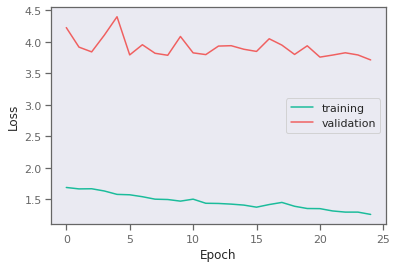

In [59]:
plt.plot(result.history['loss'], label='training')
plt.plot(result.history['val_loss'], label='validation')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

As usual, we could keep training and I encourage you to explore adding regularization or modifying the architecture. Let's now see how the test data looks. 

In [107]:
# evaluate on test data
yhat = []
test_y = []
for x,y in test_data:
    yhat.extend(model(x).numpy().flatten())
    test_y.extend(y.numpy().flatten())
yhat = np.array(yhat)
test_y = np.array(test_y)

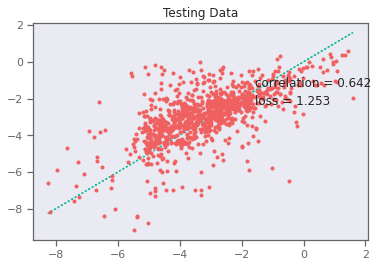

In [111]:
# plot test data
plt.plot(test_y, test_y, ':')
plt.plot(test_y, yhat, '.')
plt.text(min(y) + 1, max(y) - 2, f'correlation = {np.corrcoef(test_y, yhat)[0,1]:.3f}')
plt.text(min(y) + 1, max(y) - 3, f'loss = {np.sqrt(np.mean((test_y - yhat)**2)):.3f}')
plt.title('Testing Data')
plt.show()

Linear regression from {doc}`../ml/regression` still wins, but this demonstrates the example. 

## Transformers 

https://arxiv.org/abs/2010.09885

## Generative Models

### VAE

### Latent Space

## Materials

## Cited References

```{bibliography}
:style: unsrtalpha
:filter: docname in docnames
```